In [1]:
import sys
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, HiveContext
import os
from pyspark.sql.functions import *
import pyspark.storagelevel 
import numpy as np
import pandas as pd
import datetime
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pdb
import subprocess # Used for executing linux commands, for writing to teradata
import sys

from pyspark.sql.types import *
from pyspark.sql.functions import col, udf, min, max
from datetime import datetime, timedelta
conf = SparkConf().setMaster("local").setAppName("storeSales")
sc = SparkContext.getOrCreate(conf = conf)
sqlContext = SQLContext(sc)
hiveContext = HiveContext(sc)

## EXPLORING SALES DATA

In [111]:
# Customise field names
from pyspark.sql.types import *
fields = StructType([StructField("Store", IntegerType(), True),
       StructField("DayOfWeek", IntegerType(), True),
       StructField("Date", DateType(), True),
       StructField("Sales", IntegerType(), True),
       StructField("Customers", IntegerType(), True),
       StructField("Open", IntegerType(), True),
       StructField("Promo", IntegerType(), True),
       StructField("StateHoliday", StringType(), True),
       StructField("SchoolHoliday", StringType(), True)])

In [112]:
retail_df = hiveContext.read.format("com.databricks.spark.csv") \
  .option("header", "true") \
  .option("inferSchema", "true") \
  .load("file:///home/vijay/DATA_SCIENCE/BPF/BPF/data/ROSSMAN/rmsales.csv",schema=fields)
    
stores_df = hiveContext.read.format("com.databricks.spark.csv") \
  .option("header", "true") \
  .option("inferSchema", "true") \
  .load("file:///home/vijay/DATA_SCIENCE/BPF/BPF/data/ROSSMAN/store.csv")

In [113]:
#retail_df.cache() # I am saying after reading df just keep it in memory, irrespective of what teh dag is

In [114]:
#stores_df.cache()

In [25]:
#stores_df.unpersist()
#retail_df.unpersist()
retail_df.show(5)

+-----+---------+----------+-----+---------+----+-----+------------+-------------+
|Store|DayOfWeek|      Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|
+-----+---------+----------+-----+---------+----+-----+------------+-------------+
| 1006|        3|2014-04-02| 6641|      870|   1|    1|           0|            0|
| 1007|        3|2014-04-02| 6872|      776|   1|    1|           0|            0|
| 1008|        3|2014-04-02| 5945|      793|   1|    1|           0|            0|
| 1009|        3|2014-04-02| 4837|      484|   1|    1|           0|            0|
| 1010|        3|2014-04-02| 9349|      761|   1|    1|           0|            0|
+-----+---------+----------+-----+---------+----+-----+------------+-------------+
only showing top 5 rows



In [26]:
retail_df.count()

1017209

In [27]:
retail_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Customers: integer (nullable = true)
 |-- Open: integer (nullable = true)
 |-- Promo: integer (nullable = true)
 |-- StateHoliday: string (nullable = true)
 |-- SchoolHoliday: string (nullable = true)



In [30]:
sales_custs_df = retail_df.select( "Store", "Sales", "Customers" )
sales_custs_df.show(5)

+-----+-----+---------+
|Store|Sales|Customers|
+-----+-----+---------+
| 1006| 6641|      870|
| 1007| 6872|      776|
| 1008| 5945|      793|
| 1009| 4837|      484|
| 1010| 9349|      761|
+-----+-----+---------+
only showing top 5 rows



In [33]:
# pick only opened stores
retails_open_df = retail_df.where( retail_df.Open > 0  )
retails_open_df.show( 5 )

+-----+---------+----------+-----+---------+----+-----+------------+-------------+
|Store|DayOfWeek|      Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|
+-----+---------+----------+-----+---------+----+-----+------------+-------------+
| 1006|        3|2014-04-02| 6641|      870|   1|    1|           0|            0|
| 1007|        3|2014-04-02| 6872|      776|   1|    1|           0|            0|
| 1008|        3|2014-04-02| 5945|      793|   1|    1|           0|            0|
| 1009|        3|2014-04-02| 4837|      484|   1|    1|           0|            0|
| 1010|        3|2014-04-02| 9349|      761|   1|    1|           0|            0|
+-----+---------+----------+-----+---------+----+-----+------------+-------------+
only showing top 5 rows



In [36]:
#How many stores remained "Open" on days when it was both school and state holiday?
holidays_df= retails_open_df.where((retails_open_df.StateHoliday==1) & (retails_open_df.SchoolHoliday==1))

In [37]:
holidays_df.show()

+-----+---------+----+-----+---------+----+-----+------------+-------------+
|Store|DayOfWeek|Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|
+-----+---------+----+-----+---------+----+-----+------------+-------------+
+-----+---------+----+-----+---------+----+-----+------------+-------------+



In [39]:
#What are the total number of stores?
store_ids=retail_df.select(retail_df.Store).distinct()

In [40]:
store_ids.count()

1115

retail_df.stat.crosstab?

Computes a pair-wise frequency table of the given columns. Also known as a contingency
table. The number of distinct values for each column should be less than 1e4. At most 1e6
non-zero pair frequencies will be returned.
The first column of each row will be the distinct values of `col1` and the column names
will be the distinct values of `col2`. The name of the first column will be `$col1_$col2`.
Pairs that have no occurrences will have zero as their counts.

In [47]:
#Which weekday have maximum number of promos running
weekday_promos = retail_df.stat.crosstab( "DayOfWeek" , "Promo" )

In [48]:
weekday_promos.show( 10 )

+---------------+------+-----+
|DayOfWeek_Promo|     0|    1|
+---------------+------+-----+
|              5| 68265|77580|
|              1| 66970|77760|
|              6|144730|    0|
|              2| 68084|77580|
|              7|144730|    0|
|              3| 68085|77580|
|              4| 68265|77580|
+---------------+------+-----+



In [49]:
weekday_promos = weekday_promos.withColumnRenamed( "DayOfWeek_Promo", "DayOfWeek" )  \
                             .withColumnRenamed( "0", "NoPromo" )                  \
                             .withColumnRenamed( "1","Promo" )

In [50]:
weekday_promos.show(5)

+---------+-------+-----+
|DayOfWeek|NoPromo|Promo|
+---------+-------+-----+
|        5|  68265|77580|
|        1|  66970|77760|
|        6| 144730|    0|
|        2|  68084|77580|
|        7| 144730|    0|
+---------+-------+-----+
only showing top 5 rows



In [56]:
#Sorting dataframe by column in ascending and descending order
weekday_promos.sort( weekday_promos.Promo.desc()).show()

+---------+-------+-----+
|DayOfWeek|NoPromo|Promo|
+---------+-------+-----+
|        1|  66970|77760|
|        3|  68085|77580|
|        4|  68265|77580|
|        2|  68084|77580|
|        5|  68265|77580|
|        6| 144730|    0|
|        7| 144730|    0|
+---------+-------+-----+



In [59]:
weekday_promos.sort( "Promo", ascending = True ).show()
# no promos running on weekend

+---------+-------+-----+
|DayOfWeek|NoPromo|Promo|
+---------+-------+-----+
|        7| 144730|    0|
|        6| 144730|    0|
|        2|  68084|77580|
|        5|  68265|77580|
|        3|  68085|77580|
|        4|  68265|77580|
|        1|  66970|77760|
+---------+-------+-----+



## Assignment: Find sales revenue for each weekday.

In [ ]:
#Add a month column

In [ ]:
from pyspark.sql.functions import month, year

In [66]:
retail_df = retail_df.withColumn( 'month', month( retail_df.Date ))
retail_df = retail_df.withColumn( 'year', year( retail_df.Date ))

In [67]:
retail_df.show( 5 )

+-----+---------+----------+-----+---------+----+-----+------------+-------------+-----+----+
|Store|DayOfWeek|      Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|month|year|
+-----+---------+----------+-----+---------+----+-----+------------+-------------+-----+----+
| 1006|        3|2014-04-02| 6641|      870|   1|    1|           0|            0|    4|2014|
| 1007|        3|2014-04-02| 6872|      776|   1|    1|           0|            0|    4|2014|
| 1008|        3|2014-04-02| 5945|      793|   1|    1|           0|            0|    4|2014|
| 1009|        3|2014-04-02| 4837|      484|   1|    1|           0|            0|    4|2014|
| 1010|        3|2014-04-02| 9349|      761|   1|    1|           0|            0|    4|2014|
+-----+---------+----------+-----+---------+----+-----+------------+-------------+-----+----+
only showing top 5 rows



In [68]:
#Data Aggregations

In [69]:
sales_by_stores = retail_df.groupBy("Store").sum("Sales")

In [70]:
sales_by_stores.show( 5 )

+-----+----------+
|Store|sum(Sales)|
+-----+----------+
| 1088|   3960984|
|  148|   6772949|
|  463|   4747749|
|  471|   4422266|
|  496|   6059458|
+-----+----------+
only showing top 5 rows



In [73]:
#Multiple Aggregation
sales_by_stores_custs = retail_df.groupBy( "Store" ).agg( { "Sales" :"sum", "Customers": "sum" } )
sales_by_stores_custs.show( 5 )

+-----+----------+--------------+
|Store|sum(Sales)|sum(Customers)|
+-----+----------+--------------+
| 1088|   3960984|        377930|
|  148|   6772949|        642470|
|  463|   4747749|        755184|
|  471|   4422266|        367107|
|  496|   6059458|        650918|
+-----+----------+--------------+
only showing top 5 rows



In [74]:
#Top 10 stores by sales contribution
sales_by_stores_custs.sort( "sum(Sales)", ascending = False ).show(10)

+-----+----------+--------------+
|Store|sum(Sales)|sum(Customers)|
+-----+----------+--------------+
|  262|  19516842|       3204694|
|  817|  17057867|       2454370|
|  562|  16927322|       2924960|
| 1114|  16202585|       2509542|
|  251|  14896870|       1908934|
|  513|  14252406|       1643527|
|  788|  14082141|       1346835|
|  733|  14067158|       3206058|
|  383|  13489879|       1720249|
|  756|  12911782|       1827980|
+-----+----------+--------------+
only showing top 10 rows



In [75]:
#Average purchase value by customers in each store
from pyspark.sql.functions import col, round

In [76]:
sales_by_stores_custs = sales_by_stores_custs.withColumn(
  "avg_purchase_val",
  round( col( "sum(Sales)" ) / col( "sum(Customers)" ), 2) )

In [79]:
sales_by_stores_custs.show( 10 )

+-----+----------+--------------+----------------+
|Store|sum(Sales)|sum(Customers)|avg_purchase_val|
+-----+----------+--------------+----------------+
| 1088|   3960984|        377930|           10.48|
|  148|   6772949|        642470|           10.54|
|  463|   4747749|        755184|            6.29|
|  471|   4422266|        367107|           12.05|
|  496|   6059458|        650918|            9.31|
|  833|   4293342|        394316|           10.89|
| 1025|   5762189|        672559|            8.57|
| 1084|   4904211|        631824|            7.76|
|  243|   4407146|        594010|            7.42|
|  392|   5670675|        559386|           10.14|
+-----+----------+--------------+----------------+
only showing top 10 rows



In [82]:
avg_purchse_val = sales_by_stores_custs.sort( "avg_purchase_val", ascending = False )
# ANALYSE DATA IN PANDAS
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [83]:
top_10_avg_purchse_val = avg_purchse_val.toPandas()
top_10_avg_purchse_val.head( 10 )

,Store,sum(Sales),sum(Customers),avg_purchase_val
0,842,11553523,714829,16.16
1,612,4246423,264263,16.07
2,455,5727571,359933,15.91
3,158,6354198,405068,15.69
4,52,4607742,313176,14.71
5,868,7480652,509296,14.69
6,1115,4922229,337884,14.57
7,540,3513672,243396,14.44
8,56,5718290,395919,14.44
9,1068,3451074,240516,14.35


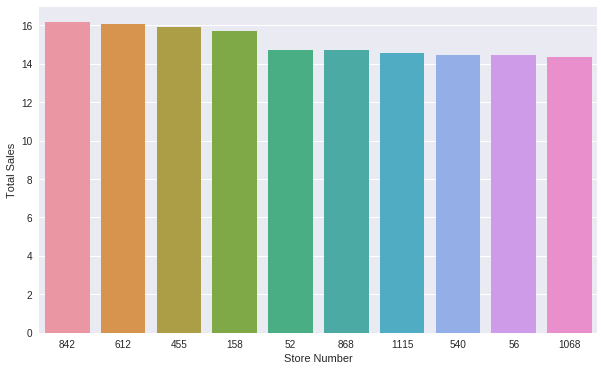

In [84]:
#Visualizing top 10 stores by avg_purchase_val
sn.set(rc={"figure.figsize": (10, 6)});

ax = sn.barplot( x = 'Store',
         y = 'avg_purchase_val' ,
         data = top_10_avg_purchse_val[0:10],
         order = top_10_avg_purchse_val.Store[0:10] )

ax.set( xlabel='Store Number',
     ylabel='Total Sales')
plt.show()

In [115]:
stores_df.show( 5 )

+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+---------------+
|Store|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|Promo2|Promo2SinceWeek|Promo2SinceYear|  PromoInterval|
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+---------------+
|    1|        c|         a|               1270|                        9|                    2008|     0|           null|           null|           null|
|    2|        a|         a|                570|                       11|                    2007|     1|             13|           2010|Jan,Apr,Jul,Oct|
|    3|        a|         a|              14130|                       12|                    2006|     1|             14|           2011|Jan,Apr,Jul,Oct|
|    4|        c|         c|                620|                      

In [116]:
#How many different types of stores are there?
store_by_types = stores_df.groupBy("StoreType").count()

In [117]:
store_by_types.sort("StoreType",ascending=True).show()

+---------+-----+
|StoreType|count|
+---------+-----+
|        a|  602|
|        b|   17|
|        c|  148|
|        d|  348|
+---------+-----+



In [118]:
#Different store types in percentages
total = stores_df.count()
total

1115

In [119]:
from pyspark.sql.functions import lit

In [120]:
#store_by_types.withColumn("percentage", round( col( "count" ) / lit( total ), 2) ).show()
store_by_types.withColumn("percentage", round( col( "count" ) / ( total ), 2) ).show()

+---------+-----+----------+
|StoreType|count|percentage|
+---------+-----+----------+
|        d|  348|      0.31|
|        c|  148|      0.13|
|        b|   17|      0.02|
|        a|  602|      0.54|
+---------+-----+----------+



In [127]:
#How long competitions exist for the stores? already have this field
stores_df = stores_df.withColumn(
  "CompetitionOpenSinceMonth",
  stores_df["CompetitionOpenSinceMonth"].cast( 'float' ) )

stores_df = stores_df.withColumn(
  "CompetitionOpenSinceYear",
  stores_df["CompetitionOpenSinceYear"].cast( 'float' ) )
stores_df = stores_df.fillna( 0.0 )
stores_df.where( col( "CompetitionOpenSinceYear" ).isNull() ).show()

+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+
|Store|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|Promo2|Promo2SinceWeek|Promo2SinceYear|PromoInterval|
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+



In [128]:
stores_df.where( col( "CompetitionOpenSinceMonth" ).isNull() ).show()

+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+
|Store|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|Promo2|Promo2SinceWeek|Promo2SinceYear|PromoInterval|
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+



In [129]:
from dateutil.relativedelta import relativedelta
from datetime import datetime
import math

def diff_in_months( fromYear, fromMonth ):
    if (fromYear == 0.0) or (fromMonth == 0.0):
        return 0.0
    else:
        return ( 2015.0 - fromYear ) * 12.0 + ( 12.0 - fromMonth )

In [130]:
diff_in_months( 2011, 2 )

58.0

In [131]:
from pyspark.sql.functions import udf, array

In [132]:
comp_months_udf = udf( diff_in_months, FloatType() )

In [133]:
stores_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: integer (nullable = true)
 |-- CompetitionOpenSinceMonth: float (nullable = false)
 |-- CompetitionOpenSinceYear: float (nullable = false)
 |-- Promo2: integer (nullable = true)
 |-- Promo2SinceWeek: integer (nullable = true)
 |-- Promo2SinceYear: integer (nullable = true)
 |-- PromoInterval: string (nullable = true)



In [134]:
stores_df = stores_df.withColumn("comp_months",
                   comp_months_udf( stores_df.CompetitionOpenSinceYear,
                                stores_df.CompetitionOpenSinceMonth ) )

In [135]:
stores_df.show(2)

+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+---------------+-----------+
|Store|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|Promo2|Promo2SinceWeek|Promo2SinceYear|  PromoInterval|comp_months|
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+---------------+-----------+
|    1|        c|         a|               1270|                      9.0|                  2008.0|     0|              0|              0|           null|       87.0|
|    2|        a|         a|                570|                     11.0|                  2007.0|     1|             13|           2010|Jan,Apr,Jul,Oct|       97.0|
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+---------------+-----------

## Advanced OLAP functions
#Creating multi-dimensional cubes for sales on customers, month, year, promo, weekday dimensions

In [137]:
retail_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Customers: integer (nullable = true)
 |-- Open: integer (nullable = true)
 |-- Promo: integer (nullable = true)
 |-- StateHoliday: string (nullable = true)
 |-- SchoolHoliday: string (nullable = true)



In [139]:
sales_cubes = retail_df.cube("Date", "DayOfWeek").avg("Sales")

In [140]:
sales_cubes = sales_cubes.sort( "Date","DayOfWeek",
                             ascending = [False, False] )

In [141]:
sales_cubes.show(65)

+----------+---------+------------------+
|      Date|DayOfWeek|        avg(Sales)|
+----------+---------+------------------+
|2015-07-31|        5| 9067.033183856502|
|2015-07-31|     null| 9067.033183856502|
|2015-07-30|        4| 7891.348878923767|
|2015-07-30|     null| 7891.348878923767|
|2015-07-29|        3| 7623.284304932736|
|2015-07-29|     null| 7623.284304932736|
|2015-07-28|        2| 8174.953363228699|
|2015-07-28|     null| 8174.953363228699|
|2015-07-27|        1| 9602.952466367713|
|2015-07-27|     null| 9602.952466367713|
|2015-07-26|        7| 256.3811659192825|
|2015-07-26|     null| 256.3811659192825|
|2015-07-25|        6|  5400.59730941704|
|2015-07-25|     null|  5400.59730941704|
|2015-07-24|        5| 5920.470852017937|
|2015-07-24|     null| 5920.470852017937|
|2015-07-23|        4| 5997.370403587444|
|2015-07-23|     null| 5997.370403587444|
|2015-07-22|        3| 5480.168609865471|
|2015-07-22|     null| 5480.168609865471|
|2015-07-21|        2| 5700.880717

In [144]:
#retail_df.cube?

In [145]:
custs_rollups = retail_df.rollup( "Date", "DayOfWeek" ).sum("Customers")

In [146]:
custs_rollups = custs_rollups.sort( "Date", "DayOfWeek",
                             ascending = [False, False] )

In [148]:
custs_rollups.show(10)

+----------+---------+--------------+
|      Date|DayOfWeek|sum(Customers)|
+----------+---------+--------------+
|2015-07-31|        5|        968620|
|2015-07-31|     null|        968620|
|2015-07-30|        4|        858547|
|2015-07-30|     null|        858547|
|2015-07-29|        3|        828524|
|2015-07-29|     null|        828524|
|2015-07-28|        2|        876092|
|2015-07-28|     null|        876092|
|2015-07-27|        1|        970462|
|2015-07-27|     null|        970462|
+----------+---------+--------------+
only showing top 10 rows



In [149]:
#Joining two dataframes
stores_limited_df = stores_df.select( 'Store',
                                    'StoreType',
                                    'Assortment',
                                    'CompetitionDistance',
                                    'comp_months')
stores_limited_df.show(10)

+-----+---------+----------+-------------------+-----------+
|Store|StoreType|Assortment|CompetitionDistance|comp_months|
+-----+---------+----------+-------------------+-----------+
|    1|        c|         a|               1270|       87.0|
|    2|        a|         a|                570|       97.0|
|    3|        a|         a|              14130|      108.0|
|    4|        c|         c|                620|       75.0|
|    5|        a|         a|              29910|        8.0|
|    6|        a|         a|                310|       24.0|
|    7|        a|         c|              24000|       32.0|
|    8|        a|         a|               7520|       14.0|
|    9|        a|         c|               2030|      184.0|
|   10|        a|         a|               3160|       75.0|
+-----+---------+----------+-------------------+-----------+
only showing top 10 rows



In [150]:
sales_by_stores_custs.show(10)

+-----+----------+--------------+----------------+
|Store|sum(Sales)|sum(Customers)|avg_purchase_val|
+-----+----------+--------------+----------------+
| 1088|   3960984|        377930|           10.48|
|  148|   6772949|        642470|           10.54|
|  463|   4747749|        755184|            6.29|
|  471|   4422266|        367107|           12.05|
|  496|   6059458|        650918|            9.31|
|  833|   4293342|        394316|           10.89|
| 1025|   5762189|        672559|            8.57|
| 1084|   4904211|        631824|            7.76|
|  243|   4407146|        594010|            7.42|
|  392|   5670675|        559386|           10.14|
+-----+----------+--------------+----------------+
only showing top 10 rows



In [151]:
all_stores_df = stores_limited_df.join( sales_by_stores_custs,
                                     on = ["Store"], how = 'inner' )

In [152]:
all_stores_df.show(10)

+-----+---------+----------+-------------------+-----------+----------+--------------+----------------+
|Store|StoreType|Assortment|CompetitionDistance|comp_months|sum(Sales)|sum(Customers)|avg_purchase_val|
+-----+---------+----------+-------------------+-----------+----------+--------------+----------------+
| 1088|        a|         a|               4300|       81.0|   3960984|        377930|           10.48|
|  148|        a|         a|               2090|       84.0|   6772949|        642470|           10.54|
|  463|        a|         a|               4160|        0.0|   4747749|        755184|            6.29|
|  471|        d|         a|               5300|        0.0|   4422266|        367107|           12.05|
|  496|        d|         c|               2780|        6.0|   6059458|        650918|            9.31|
|  833|        d|         c|               3290|      192.0|   4293342|        394316|           10.89|
| 1025|        a|         a|                720|       73.0|   5

In [153]:
#Statistical Functions
all_stores_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: integer (nullable = true)
 |-- comp_months: float (nullable = true)
 |-- sum(Sales): long (nullable = true)
 |-- sum(Customers): long (nullable = true)
 |-- avg_purchase_val: double (nullable = true)



In [154]:
all_stores_stats = all_stores_df.describe()

In [155]:
all_stores_stats.show()

+-------+-----------------+---------+----------+-------------------+-----------------+------------------+-----------------+------------------+
|summary|            Store|StoreType|Assortment|CompetitionDistance|      comp_months|        sum(Sales)|   sum(Customers)|  avg_purchase_val|
+-------+-----------------+---------+----------+-------------------+-----------------+------------------+-----------------+------------------+
|  count|             1115|     1115|      1115|               1115|             1115|              1115|             1115|              1115|
|   mean|            558.0|     null|      null|  5390.358744394619|55.11210762331839| 5267426.567713005|577615.9237668162| 9.643659192825114|
| stddev|322.0170802923348|     null|      null| 7657.9737053313265| 71.9420584393018|1951304.4839653838|304654.5331405179|1.9869552301495716|
|    min|                1|        a|         a|                  0|              0.0|           2114322|           187583|              3.51|

In [156]:
#Convert the data types of the columns
all_stores_df = all_stores_df.withColumn(
  "CompetitionDistance",
  all_stores_df["CompetitionDistance"].cast('int'))

In [157]:
all_stores_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: integer (nullable = true)
 |-- comp_months: float (nullable = true)
 |-- sum(Sales): long (nullable = true)
 |-- sum(Customers): long (nullable = true)
 |-- avg_purchase_val: double (nullable = true)



In [158]:
all_stores_stats = all_stores_df.describe()
all_stores_stats.show()

+-------+-----------------+---------+----------+-------------------+-----------------+------------------+-----------------+------------------+
|summary|            Store|StoreType|Assortment|CompetitionDistance|      comp_months|        sum(Sales)|   sum(Customers)|  avg_purchase_val|
+-------+-----------------+---------+----------+-------------------+-----------------+------------------+-----------------+------------------+
|  count|             1115|     1115|      1115|               1115|             1115|              1115|             1115|              1115|
|   mean|            558.0|     null|      null|  5390.358744394619|55.11210762331839| 5267426.567713005|577615.9237668162| 9.643659192825114|
| stddev|322.0170802923348|     null|      null| 7657.9737053313265| 71.9420584393018|1951304.4839653838|304654.5331405179|1.9869552301495716|
|    min|                1|        a|         a|                  0|              0.0|           2114322|           187583|              3.51|

In [159]:
all_stores_df.describe( "CompetitionDistance", "avg_purchase_val" ).show()

+-------+-------------------+------------------+
|summary|CompetitionDistance|  avg_purchase_val|
+-------+-------------------+------------------+
|  count|               1115|              1115|
|   mean|  5390.358744394619| 9.643659192825114|
| stddev| 7657.9737053313265|1.9869552301495716|
|    min|                  0|              3.51|
|    max|              75860|             16.16|
+-------+-------------------+------------------+



In [160]:
#Finding correlation between variables
all_stores_df.stat.corr('CompetitionDistance', 'avg_purchase_val')

0.23007011949360362

Surprisingly not very highly correlated. In fact, it is positively correlated, which sound unintuitive. This may be because the stores with low CompetitionDistance are located in crowded places. And Stores with high competition distance are placed in very low population areas. This explains why the sales are low, even when there is no competition

In [161]:
all_stores_df.stat.corr( 'sum(Sales)', 'sum(Customers)' )

0.8542650646315252

This is expected to be highly correlated. Sales are higher when when there are higher footfalls

In [162]:
# read,https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html

In [164]:
#Registering sales data as a table
retail_df.registerTempTable( "retail" )

In [167]:
#Running SQL Queries
avg_sales_custs = hiveContext.sql( """select Store, avg(Sales) as avg_sales,                 
                                 avg(Customers) as avg_custs from retail group by Store""" )
#avg_sales_custs.cache()

In [168]:
avg_sales_custs.show(10)

+-----+------------------+------------------+
|Store|         avg_sales|         avg_custs|
+-----+------------------+------------------+
| 1088| 4204.866242038216| 401.1995753715499|
|  148| 7189.967091295117| 682.0276008492569|
|  463| 5040.073248407643| 801.6815286624204|
|  471|  5834.12401055409|484.31002638522426|
|  496| 6432.545647558386|  690.995753715499|
|  833|4557.6878980891715| 418.5944798301486|
| 1025| 6116.973460721868| 713.9692144373673|
| 1084| 5206.168789808918| 670.7261146496816|
|  243| 5814.176781002639| 783.6543535620053|
|  392| 6019.824840764331|  593.828025477707|
+-----+------------------+------------------+
only showing top 10 rows



In [170]:
#Creating Cubes and Rollups
hiveContext.sql( "describe retail").show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|        Store|      int|   null|
|    DayOfWeek|      int|   null|
|         Date|     date|   null|
|        Sales|      int|   null|
|    Customers|      int|   null|
|         Open|      int|   null|
|        Promo|      int|   null|
| StateHoliday|   string|   null|
|SchoolHoliday|   string|   null|
+-------------+---------+-------+



In [173]:
sales_rollups = hiveContext.sql( '''select Date, Store, sum(Sales) as total_sales
            from retail group by Date, Store with rollup''')

In [174]:
sales_rollups.show(10)

+----------+-----+-----------+
|      Date|Store|total_sales|
+----------+-----+-----------+
|2014-04-01|  163|       9459|
|2014-04-01|  171|      11731|
|2014-04-01|  206|       8501|
|2014-04-01|  271|       9550|
|2014-04-01|  840|       9544|
|2014-03-31|    8|       8934|
|2014-03-31|  272|      12696|
|2014-03-31|  431|      13210|
|2014-03-31|  794|       3447|
|2014-03-31|  796|      10530|
+----------+-----+-----------+
only showing top 10 rows



In [175]:
sales_rollups.dropna().registerTempTable( "sales_rollups" )

In [181]:
#Top 3 Stores for each month by sales revenue contribution
top3_query = """SELECT
  Date,
  Store,
  total_sales,
  rank
FROM (
  SELECT
    Store,
    Date,
    total_sales,
    rank() OVER (PARTITION BY Date ORDER BY total_sales DESC) as rank
  FROM sales_rollups) tmp
WHERE
  rank <= 3 ORDER BY Date, rank"""


In [182]:
top3_store_by_month = hiveContext.sql(top3_query)
top3_store_by_month.show(10)

+----------+-----+-----------+----+
|      Date|Store|total_sales|rank|
+----------+-----+-----------+----+
|2013-01-01|  262|      17267|   1|
|2013-01-01|  733|      10765|   2|
|2013-01-01|  423|       9643|   3|
|2013-01-02|  817|      25357|   1|
|2013-01-02| 1114|      20642|   2|
|2013-01-02|  523|      20493|   3|
|2013-01-03|  817|      23303|   1|
|2013-01-03|  842|      18995|   2|
|2013-01-03|  513|      18469|   3|
|2013-01-04|  817|      21996|   1|
+----------+-----+-----------+----+
only showing top 10 rows



In [185]:
retail_df.write.parquet("file:///home/vijay/DATA_SCIENCE/BPF/BPF/data/ROSSMAN/retail.parquet")
stores_limited_df.write.parquet( "file:///home/vijay/DATA_SCIENCE/BPF/BPF/data/ROSSMAN/stores_limited.parquet" )

## will build a model predict sales in various stores and use spark framework to explore and build predictive model

In [4]:
retail_df = hiveContext.read.parquet("file:///home/vijay/DATA_SCIENCE/BPF/BPF/data/ROSSMAN/retail.parquet")
retail_df.show(5)

+-----+---------+----------+-----+---------+----+-----+------------+-------------+
|Store|DayOfWeek|      Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|
+-----+---------+----------+-----+---------+----+-----+------------+-------------+
| 1006|        3|2014-04-02| 6641|      870|   1|    1|           0|            0|
| 1007|        3|2014-04-02| 6872|      776|   1|    1|           0|            0|
| 1008|        3|2014-04-02| 5945|      793|   1|    1|           0|            0|
| 1009|        3|2014-04-02| 4837|      484|   1|    1|           0|            0|
| 1010|        3|2014-04-02| 9349|      761|   1|    1|           0|            0|
+-----+---------+----------+-----+---------+----+-----+------------+-------------+
only showing top 5 rows



In [5]:
retail_df = retail_df.withColumn( 'month', month( retail_df.Date ))
retail_df = retail_df.withColumn( 'year', year( retail_df.Date ))
retail_df.show(5)
#Returns a new :class:`DataFrame` by adding a column or replacing the
#existing column that has the same name.

+-----+---------+----------+-----+---------+----+-----+------------+-------------+-----+----+
|Store|DayOfWeek|      Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|month|year|
+-----+---------+----------+-----+---------+----+-----+------------+-------------+-----+----+
| 1006|        3|2014-04-02| 6641|      870|   1|    1|           0|            0|    4|2014|
| 1007|        3|2014-04-02| 6872|      776|   1|    1|           0|            0|    4|2014|
| 1008|        3|2014-04-02| 5945|      793|   1|    1|           0|            0|    4|2014|
| 1009|        3|2014-04-02| 4837|      484|   1|    1|           0|            0|    4|2014|
| 1010|        3|2014-04-02| 9349|      761|   1|    1|           0|            0|    4|2014|
+-----+---------+----------+-----+---------+----+-----+------------+-------------+-----+----+
only showing top 5 rows



In [10]:
#retail_df.withColumn?

In [11]:
retail_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Customers: integer (nullable = true)
 |-- Open: integer (nullable = true)
 |-- Promo: integer (nullable = true)
 |-- StateHoliday: string (nullable = true)
 |-- SchoolHoliday: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)



In [13]:
stores_df = hiveContext.read.parquet("file:///home/vijay/DATA_SCIENCE/BPF/BPF/data/ROSSMAN/stores_limited.parquet")
stores_df.show( 5 )

+-----+---------+----------+-------------------+-----------+
|Store|StoreType|Assortment|CompetitionDistance|comp_months|
+-----+---------+----------+-------------------+-----------+
|    1|        c|         a|               1270|       87.0|
|    2|        a|         a|                570|       97.0|
|    3|        a|         a|              14130|      108.0|
|    4|        c|         c|                620|       75.0|
|    5|        a|         a|              29910|        8.0|
+-----+---------+----------+-------------------+-----------+
only showing top 5 rows



In [40]:
stores_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: float (nullable = true)
 |-- comp_months: float (nullable = true)



In [41]:
#CompetitionDistance seems to be a int types. It need to be converted into a float variable
stores_df = stores_df.withColumn( "CompetitionDistance",
                   stores_df["CompetitionDistance"].cast( 'float' ) )
stores_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: float (nullable = true)
 |-- comp_months: float (nullable = true)



In [42]:
#To predict sales of stores we can use the following features to make prediction
store_sales_df = retail_df.select('Store',
'DayOfWeek',
'Promo',
'StateHoliday',
'SchoolHoliday',
'month',
'year',
'Sales',
)

In [43]:
store_sales_df.show(10)

+-----+---------+-----+------------+-------------+-----+----+-----+
|Store|DayOfWeek|Promo|StateHoliday|SchoolHoliday|month|year|Sales|
+-----+---------+-----+------------+-------------+-----+----+-----+
| 1006|        3|    1|           0|            0|    4|2014| 6641|
| 1007|        3|    1|           0|            0|    4|2014| 6872|
| 1008|        3|    1|           0|            0|    4|2014| 5945|
| 1009|        3|    1|           0|            0|    4|2014| 4837|
| 1010|        3|    1|           0|            0|    4|2014| 9349|
| 1011|        3|    1|           0|            0|    4|2014| 9483|
| 1012|        3|    1|           0|            0|    4|2014| 6081|
| 1013|        3|    1|           0|            0|    4|2014| 4833|
| 1014|        3|    1|           0|            0|    4|2014|14600|
| 1015|        3|    1|           0|            0|    4|2014| 5820|
+-----+---------+-----+------------+-------------+-----+----+-----+
only showing top 10 rows



In [44]:
store_sales_df = store_sales_df.join(stores_df,on="Store",how="inner")

In [45]:
store_sales_df.show(10)

+-----+---------+-----+------------+-------------+-----+----+-----+---------+----------+-------------------+-----------+
|Store|DayOfWeek|Promo|StateHoliday|SchoolHoliday|month|year|Sales|StoreType|Assortment|CompetitionDistance|comp_months|
+-----+---------+-----+------------+-------------+-----+----+-----+---------+----------+-------------------+-----------+
| 1006|        3|    1|           0|            0|    4|2014| 6641|        c|         c|             3890.0|      109.0|
| 1007|        3|    1|           0|            0|    4|2014| 6872|        c|         c|             4180.0|       39.0|
| 1008|        3|    1|           0|            0|    4|2014| 5945|        a|         c|               30.0|       63.0|
| 1009|        3|    1|           0|            0|    4|2014| 4837|        a|         a|              230.0|      137.0|
| 1010|        3|    1|           0|            0|    4|2014| 9349|        d|         c|             4610.0|       66.0|
| 1011|        3|    1|         

In [46]:
store_sales_df.columns

['Store',
 'DayOfWeek',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'month',
 'year',
 'Sales',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'comp_months']

In [47]:
#Remove rows with 0 Sales,this can only mean store was closed
store_sales_df = store_sales_df.where(store_sales_df.Sales>0)

In [48]:
#Fill all null values with zero for calculation ease
store_sales_df.fillna(0)

DataFrame[Store: int, DayOfWeek: int, Promo: int, StateHoliday: string, SchoolHoliday: string, month: int, year: int, Sales: int, StoreType: string, Assortment: string, CompetitionDistance: float, comp_months: float]

In [49]:
store_sales_df = store_sales_df.na.drop( how = 'any' )

In [50]:
#Which are categorical and which are continuous features?
cat_features = ['DayOfWeek',
              'Promo',
              'StateHoliday',
              'SchoolHoliday',
              'month',
              'year',
              'StoreType',
              'Assortment']
cat_features

['DayOfWeek',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'month',
 'year',
 'StoreType',
 'Assortment']

In [51]:
continuous_features = ['CompetitionDistance', 'comp_months']
continuous_features

['CompetitionDistance', 'comp_months']

In [52]:
#Function to encode categorical features
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, PolynomialExpansion, VectorIndexer


def create_category_vars( dataset, field_name ):
    idx_col = field_name + "Index"
    col_ver = field_name + "Vec"
    
    string_indxer = StringIndexer(inputCol=field_name,outputCol=idx_col)
    
    mymodel = string_indxer.fit(dataset)
    indexed = mymodel.transform(dataset)
    
    string_encoder = OneHotEncoder(dropLast=True,inputCol=idx_col,outputCol=col_ver)
    
    return string_encoder.transform(indexed)

In [53]:
for col in cat_features:
    store_sales_df = create_category_vars( store_sales_df, col )

+-----+---------+-----+------------+-------------+-----+----+-----+---------+----------+-------------------+-----------+--------------+-------------+----------+---------+-----------------+---------------+------------------+----------------+----------+--------------+---------+-------------+--------------+-------------+---------------+-------------+
|Store|DayOfWeek|Promo|StateHoliday|SchoolHoliday|month|year|Sales|StoreType|Assortment|CompetitionDistance|comp_months|DayOfWeekIndex| DayOfWeekVec|PromoIndex| PromoVec|StateHolidayIndex|StateHolidayVec|SchoolHolidayIndex|SchoolHolidayVec|monthIndex|      monthVec|yearIndex|      yearVec|StoreTypeIndex| StoreTypeVec|AssortmentIndex|AssortmentVec|
+-----+---------+-----+------------+-------------+-----+----+-----+---------+----------+-------------------+-----------+--------------+-------------+----------+---------+-----------------+---------------+------------------+----------------+----------+--------------+---------+-------------+----------

In [56]:
store_sales_df.take(1) # categorical data is represented as vertex ie numerical form(ombination of index and somehg else)

[Row(Store=1006, DayOfWeek=3, Promo=1, StateHoliday=u'0', SchoolHoliday=u'0', month=4, year=2014, Sales=6641, StoreType=u'c', Assortment=u'c', CompetitionDistance=3890.0, comp_months=109.0, DayOfWeekIndex=2.0, DayOfWeekVec=SparseVector(6, {2: 1.0}), PromoIndex=1.0, PromoVec=SparseVector(1, {}), StateHolidayIndex=0.0, StateHolidayVec=SparseVector(3, {0: 1.0}), SchoolHolidayIndex=0.0, SchoolHolidayVec=SparseVector(1, {0: 1.0}), monthIndex=4.0, monthVec=SparseVector(11, {4: 1.0}), yearIndex=1.0, yearVec=SparseVector(2, {1: 1.0}), StoreTypeIndex=2.0, StoreTypeVec=SparseVector(3, {2: 1.0}), AssortmentIndex=1.0, AssortmentVec=SparseVector(2, {1: 1.0}))]

In [55]:
store_sales_df.columns

['Store',
 'DayOfWeek',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'month',
 'year',
 'Sales',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'comp_months',
 'DayOfWeekIndex',
 'DayOfWeekVec',
 'PromoIndex',
 'PromoVec',
 'StateHolidayIndex',
 'StateHolidayVec',
 'SchoolHolidayIndex',
 'SchoolHolidayVec',
 'monthIndex',
 'monthVec',
 'yearIndex',
 'yearVec',
 'StoreTypeIndex',
 'StoreTypeVec',
 'AssortmentIndex',
 'AssortmentVec']

In [58]:
categorical_vecs = [ "".join( (cat, "Vec") ) for cat in cat_features ]

In [59]:
categorical_vecs

['DayOfWeekVec',
 'PromoVec',
 'StateHolidayVec',
 'SchoolHolidayVec',
 'monthVec',
 'yearVec',
 'StoreTypeVec',
 'AssortmentVec']

In [61]:
#Including all features for model building
all_features = continuous_features + categorical_vecs

In [62]:
all_features

['CompetitionDistance',
 'comp_months',
 'DayOfWeekVec',
 'PromoVec',
 'StateHolidayVec',
 'SchoolHolidayVec',
 'monthVec',
 'yearVec',
 'StoreTypeVec',
 'AssortmentVec']

In [63]:
#Creating the vector of all predictors
assembler = VectorAssembler( inputCols = all_features, outputCol = "features")

In [64]:
store_sales_df = assembler.transform( store_sales_df )

In [65]:
store_sales_df.take(1)

[Row(Store=1006, DayOfWeek=3, Promo=1, StateHoliday=u'0', SchoolHoliday=u'0', month=4, year=2014, Sales=6641, StoreType=u'c', Assortment=u'c', CompetitionDistance=3890.0, comp_months=109.0, DayOfWeekIndex=2.0, DayOfWeekVec=SparseVector(6, {2: 1.0}), PromoIndex=1.0, PromoVec=SparseVector(1, {}), StateHolidayIndex=0.0, StateHolidayVec=SparseVector(3, {0: 1.0}), SchoolHolidayIndex=0.0, SchoolHolidayVec=SparseVector(1, {0: 1.0}), monthIndex=4.0, monthVec=SparseVector(11, {4: 1.0}), yearIndex=1.0, yearVec=SparseVector(2, {1: 1.0}), StoreTypeIndex=2.0, StoreTypeVec=SparseVector(3, {2: 1.0}), AssortmentIndex=1.0, AssortmentVec=SparseVector(2, {1: 1.0}), features=SparseVector(31, {0: 3890.0, 1: 109.0, 4: 1.0, 9: 1.0, 12: 1.0, 17: 1.0, 25: 1.0, 28: 1.0, 30: 1.0}))]

In [66]:
#Setting the target variables - Sales
store_sales_df = store_sales_df.withColumn( "label", store_sales_df.Sales.cast( 'double' ) )

In [67]:
store_sales_df.take(1)

[Row(Store=1006, DayOfWeek=3, Promo=1, StateHoliday=u'0', SchoolHoliday=u'0', month=4, year=2014, Sales=6641, StoreType=u'c', Assortment=u'c', CompetitionDistance=3890.0, comp_months=109.0, DayOfWeekIndex=2.0, DayOfWeekVec=SparseVector(6, {2: 1.0}), PromoIndex=1.0, PromoVec=SparseVector(1, {}), StateHolidayIndex=0.0, StateHolidayVec=SparseVector(3, {0: 1.0}), SchoolHolidayIndex=0.0, SchoolHolidayVec=SparseVector(1, {0: 1.0}), monthIndex=4.0, monthVec=SparseVector(11, {4: 1.0}), yearIndex=1.0, yearVec=SparseVector(2, {1: 1.0}), StoreTypeIndex=2.0, StoreTypeVec=SparseVector(3, {2: 1.0}), AssortmentIndex=1.0, AssortmentVec=SparseVector(2, {1: 1.0}), features=SparseVector(31, {0: 3890.0, 1: 109.0, 4: 1.0, 9: 1.0, 12: 1.0, 17: 1.0, 25: 1.0, 28: 1.0, 30: 1.0}), label=6641.0)]

In [68]:
store_sales_df.select( "features", "label" ).show( 5 )

+--------------------+------+
|            features| label|
+--------------------+------+
|(31,[0,1,4,9,12,1...|6641.0|
|(31,[0,1,4,9,12,1...|6872.0|
|(31,[0,1,4,9,12,1...|5945.0|
|(31,[0,1,4,9,12,1...|4837.0|
|(31,[0,1,4,9,12,1...|9349.0|
+--------------------+------+
only showing top 5 rows



In [70]:
#Split the dataset
seed = 42
train_df, test_df = store_sales_df.randomSplit( [0.6, 0.4], seed = seed )

In [72]:
#Train Linear Regression Model
from pyspark.ml.regression import LinearRegression
linreg = LinearRegression(maxIter=500, regParam=0.0)
lm = linreg.fit( train_df )

In [73]:
lm.intercept

10573.789134035513

In [74]:
lm.coefficients

DenseVector([-0.0154, 0.2568, -147.8423, -264.4089, -590.8483, -195.4261, 820.0042, -559.3289, -2307.1274, 1697.2213, 1787.188, 1711.7779, -298.7154, -2111.8542, -1800.7318, -1905.5925, -1670.6516, -1681.1365, -2014.0603, -1574.7404, -2080.5265, -1995.8379, -2067.2286, -1489.4316, -341.8331, -156.8647, -5345.3877, -5625.6319, -5459.9039, 3352.741, 4193.2384])

In [79]:
#Making predictions on test data
y_pred = lm.transform(test_df)

In [76]:
y_pred.select( 'features', 'label', 'prediction' ).show( 5 )

+--------------------+------+-----------------+
|            features| label|       prediction|
+--------------------+------+-----------------+
|(31,[0,1,6,8,9,12...|4055.0|5927.070911996363|
|(31,[0,1,6,8,9,12...|4717.0|5927.070911996363|
|(31,[0,1,6,8,9,12...|3601.0|6112.039332218108|
|(31,[0,1,6,8,9,12...|3994.0|6112.039332218108|
|(31,[0,1,6,8,9,12...|3598.0| 6366.69786958085|
+--------------------+------+-----------------+
only showing top 5 rows



In [80]:
type(y_pred)
y_pred.take(2)

[Row(Store=1, DayOfWeek=1, Promo=0, StateHoliday=u'0', SchoolHoliday=u'0', month=1, year=2013, Sales=4055, StoreType=u'c', Assortment=u'a', CompetitionDistance=1270.0, comp_months=87.0, DayOfWeekIndex=4.0, DayOfWeekVec=SparseVector(6, {4: 1.0}), PromoIndex=0.0, PromoVec=SparseVector(1, {0: 1.0}), StateHolidayIndex=0.0, StateHolidayVec=SparseVector(3, {0: 1.0}), SchoolHolidayIndex=0.0, SchoolHolidayVec=SparseVector(1, {0: 1.0}), monthIndex=0.0, monthVec=SparseVector(11, {0: 1.0}), yearIndex=0.0, yearVec=SparseVector(2, {0: 1.0}), StoreTypeIndex=2.0, StoreTypeVec=SparseVector(3, {2: 1.0}), AssortmentIndex=0.0, AssortmentVec=SparseVector(2, {0: 1.0}), features=SparseVector(31, {0: 1270.0, 1: 87.0, 6: 1.0, 8: 1.0, 9: 1.0, 12: 1.0, 13: 1.0, 24: 1.0, 28: 1.0, 29: 1.0}), label=4055.0, prediction=5927.070911996363),
 Row(Store=1, DayOfWeek=1, Promo=0, StateHoliday=u'0', SchoolHoliday=u'0', month=1, year=2013, Sales=4717, StoreType=u'c', Assortment=u'a', CompetitionDistance=1270.0, comp_months=

In [82]:
# Calculating RMSE and R-Squared
from pyspark.ml.evaluation import RegressionEvaluator

rmse_evaluator = RegressionEvaluator(labelCol="label",
                            predictionCol="prediction",
                            metricName="rmse" )

In [83]:
lm_rmse = rmse_evaluator.evaluate( y_pred )
lm_rmse

2728.5161500194595

In [84]:
r2_evaluator = RegressionEvaluator(labelCol="label",
                            predictionCol="prediction",
                            metricName="r2" )
lm_r2 = r2_evaluator.evaluate( y_pred )
lm_r2

0.22852781376475506

Accuracy of the model is very poor. This may be because we do not have right or enough variables which can predict the sales better. We can do feature engineering to create more features

## Let's do soem feature engineering

In [85]:
#The sales might be influenced by if the next day is a holiday # obvious
#What is the sales for the last 2 and 5 days? # reactive sales

In [102]:
retail_df.show(5)

+-----+---------+----------+-----+---------+----+-----+------------+-------------+-----+----+
|Store|DayOfWeek|      Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|month|year|
+-----+---------+----------+-----+---------+----+-----+------------+-------------+-----+----+
| 1006|        3|2014-04-02| 6641|      870|   1|    1|           0|            0|    4|2014|
| 1007|        3|2014-04-02| 6872|      776|   1|    1|           0|            0|    4|2014|
| 1008|        3|2014-04-02| 5945|      793|   1|    1|           0|            0|    4|2014|
| 1009|        3|2014-04-02| 4837|      484|   1|    1|           0|            0|    4|2014|
| 1010|        3|2014-04-02| 9349|      761|   1|    1|           0|            0|    4|2014|
+-----+---------+----------+-----+---------+----+-----+------------+-------------+-----+----+
only showing top 5 rows



In [103]:
from pyspark.sql.functions import lag, col, lead
from pyspark.sql.window import Window
w =  Window().partitionBy("Store").orderBy(col("Date"))
retail_new_df = retail_df.select("*",lead("StateHoliday").over(w).alias("next_day_state_holiday"))

In [104]:
retail_new_df.show(100)

+-----+---------+----------+-----+---------+----+-----+------------+-------------+-----+----+----------------------+
|Store|DayOfWeek|      Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|month|year|next_day_state_holiday|
+-----+---------+----------+-----+---------+----+-----+------------+-------------+-----+----+----------------------+
|  148|        2|2013-01-01|    0|        0|   0|    0|           a|            1|    1|2013|                     0|
|  148|        3|2013-01-02| 7944|      781|   1|    0|           0|            1|    1|2013|                     0|
|  148|        4|2013-01-03| 7517|      753|   1|    0|           0|            1|    1|2013|                     0|
|  148|        5|2013-01-04| 7482|      721|   1|    0|           0|            1|    1|2013|                     0|
|  148|        6|2013-01-05| 7750|      756|   1|    0|           0|            0|    1|2013|                     0|
|  148|        7|2013-01-06|    0|        0|   0|    0|         

In [105]:
#Is the next day a school holiday?
w = Window().partitionBy("Store").orderBy(col("Date"))
retail_new_df = retail_new_df.select("*", lead("SchoolHoliday").over(w).alias("next_day_school_holiday"))


In [108]:
retail_new_df.select("Store","Date","StateHoliday","SchoolHoliday","next_day_state_holiday","next_day_school_holiday").show(100)

+-----+----------+------------+-------------+----------------------+-----------------------+
|Store|      Date|StateHoliday|SchoolHoliday|next_day_state_holiday|next_day_school_holiday|
+-----+----------+------------+-------------+----------------------+-----------------------+
|  148|2013-01-01|           a|            1|                     0|                      1|
|  148|2013-01-02|           0|            1|                     0|                      1|
|  148|2013-01-03|           0|            1|                     0|                      1|
|  148|2013-01-04|           0|            1|                     0|                      0|
|  148|2013-01-05|           0|            0|                     0|                      0|
|  148|2013-01-06|           0|            0|                     0|                      0|
|  148|2013-01-07|           0|            0|                     0|                      0|
|  148|2013-01-08|           0|            0|                     0|  

In [109]:
#mean sales for the last 2 days
w = Window().partitionBy("Store").orderBy("Date")
retail_new_df = retail_new_df.withColumn("avg_sales_last_2days",
                                       ( lag("Sales", 1).over(w) + lag("Sales", 2).over(w) ) / 2 )

In [111]:
retail_new_df.show(5)

+-----+---------+----------+-----+---------+----+-----+------------+-------------+-----+----+----------------------+-----------------------+--------------------+
|Store|DayOfWeek|      Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|month|year|next_day_state_holiday|next_day_school_holiday|avg_sales_last_2days|
+-----+---------+----------+-----+---------+----+-----+------------+-------------+-----+----+----------------------+-----------------------+--------------------+
|  148|        2|2013-01-01|    0|        0|   0|    0|           a|            1|    1|2013|                     0|                      1|                null|
|  148|        3|2013-01-02| 7944|      781|   1|    0|           0|            1|    1|2013|                     0|                      1|                null|
|  148|        4|2013-01-03| 7517|      753|   1|    0|           0|            1|    1|2013|                     0|                      1|              3972.0|
|  148|        5|2013-01-04|

In [112]:
#Mean sales for the last 2 days
w = Window().partitionBy("Store").orderBy("Date")

retail_new_df = retail_new_df.withColumn("avg_sales_last_5days",
                                       ( lag("Sales", 1).over(w)
                                        + lag("Sales", 2).over(w)
                                        + lag("Sales", 3).over(w)
                                        + lag("Sales", 4).over(w)
                                        + lag("Sales", 5).over(w) ) / 5 )

In [113]:
retail_new_df.show( 10 )

+-----+---------+----------+-----+---------+----+-----+------------+-------------+-----+----+----------------------+-----------------------+--------------------+--------------------+
|Store|DayOfWeek|      Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|month|year|next_day_state_holiday|next_day_school_holiday|avg_sales_last_2days|avg_sales_last_5days|
+-----+---------+----------+-----+---------+----+-----+------------+-------------+-----+----+----------------------+-----------------------+--------------------+--------------------+
|  148|        2|2013-01-01|    0|        0|   0|    0|           a|            1|    1|2013|                     0|                      1|                null|                null|
|  148|        3|2013-01-02| 7944|      781|   1|    0|           0|            1|    1|2013|                     0|                      1|                null|                null|
|  148|        4|2013-01-03| 7517|      753|   1|    0|           0|            1|   

In [114]:
#Average sales per store for each month
avg_sales_store_by_month =  retail_new_df.groupby("Store","month").avg("Sales")

In [115]:
avg_sales_store_by_month.show( 5 )

+-----+-----+------------------+
|Store|month|        avg(Sales)|
+-----+-----+------------------+
| 1010|    4| 7244.644444444444|
| 1114|    4|17492.433333333334|
|   71|    4|7290.9111111111115|
|  203|    4| 5511.066666666667|
|  248|    4|            6661.1|
+-----+-----+------------------+
only showing top 5 rows



In [116]:
retail_new_df = retail_new_df.join(avg_sales_store_by_month,on=["Store","month"],how="inner")

In [117]:
retail_new_df.show(1)

+-----+-----+---------+----------+-----+---------+----+-----+------------+-------------+----+----------------------+-----------------------+--------------------+--------------------+-----------------+
|Store|month|DayOfWeek|      Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|year|next_day_state_holiday|next_day_school_holiday|avg_sales_last_2days|avg_sales_last_5days|       avg(Sales)|
+-----+-----+---------+----------+-----+---------+----+-----+------------+-------------+----+----------------------+-----------------------+--------------------+--------------------+-----------------+
|  148|    1|        2|2013-01-01|    0|        0|   0|    0|           a|            1|2013|                     0|                      1|                null|                null|6933.451612903225|
+-----+-----+---------+----------+-----+---------+----+-----+------------+-------------+----+----------------------+-----------------------+--------------------+--------------------+--------------

In [118]:
from pyspark.sql.functions import round
retail_new_df = retail_new_df.withColumn( "avg_sales_by_month",
                                       round( retail_new_df["avg(Sales)"], 2 ) )

In [119]:
store_sales_new_df = store_sales_df = retail_new_df.select('Store',
                                                   'DayOfWeek',
                                                   'Promo',
                                                   'StateHoliday',
                                                   'SchoolHoliday',
                                                   'month',
                                                   'year',
                                                   'Sales',
                                                   'next_day_state_holiday',
                                                   'next_day_school_holiday',
                                                   'avg_sales_last_2days',
                                                   'avg_sales_last_5days',
                                                   'avg_sales_by_month'
                                                          )

In [120]:
store_sales_new_df = store_sales_new_df.join( stores_df, on = "Store", how = "inner" )

In [121]:
store_sales_new_df.show(5)

+-----+---------+-----+------------+-------------+-----+----+-----+----------------------+-----------------------+--------------------+--------------------+------------------+---------+----------+-------------------+-----------+
|Store|DayOfWeek|Promo|StateHoliday|SchoolHoliday|month|year|Sales|next_day_state_holiday|next_day_school_holiday|avg_sales_last_2days|avg_sales_last_5days|avg_sales_by_month|StoreType|Assortment|CompetitionDistance|comp_months|
+-----+---------+-----+------------+-------------+-----+----+-----+----------------------+-----------------------+--------------------+--------------------+------------------+---------+----------+-------------------+-----------+
|  148|        2|    0|           a|            1|    1|2013|    0|                     0|                      1|                null|                null|           6933.45|        a|         a|             2090.0|       84.0|
|  148|        3|    0|           0|            1|    1|2013| 7944|                 

In [122]:
#Considering the new features
cat_features_new = cat_features + ['next_day_state_holiday', 'next_day_school_holiday']
cat_features_new

['DayOfWeek',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'month',
 'year',
 'StoreType',
 'Assortment',
 'next_day_state_holiday',
 'next_day_school_holiday']

In [123]:
continuous_features_new = continuous_features + ['avg_sales_last_2days', 'avg_sales_last_5days', 'avg_sales_by_month']
continuous_features_new

['CompetitionDistance',
 'comp_months',
 'avg_sales_last_2days',
 'avg_sales_last_5days',
 'avg_sales_by_month']

In [124]:
#Encoding the categorical features
store_sales_new_df.show(5)

+-----+---------+-----+------------+-------------+-----+----+-----+----------------------+-----------------------+--------------------+--------------------+------------------+---------+----------+-------------------+-----------+
|Store|DayOfWeek|Promo|StateHoliday|SchoolHoliday|month|year|Sales|next_day_state_holiday|next_day_school_holiday|avg_sales_last_2days|avg_sales_last_5days|avg_sales_by_month|StoreType|Assortment|CompetitionDistance|comp_months|
+-----+---------+-----+------------+-------------+-----+----+-----+----------------------+-----------------------+--------------------+--------------------+------------------+---------+----------+-------------------+-----------+
|  148|        2|    0|           a|            1|    1|2013|    0|                     0|                      1|                null|                null|           6933.45|        a|         a|             2090.0|       84.0|
|  148|        3|    0|           0|            1|    1|2013| 7944|                 

In [125]:
# dropping all na
store_sales_new_df = store_sales_new_df.na.drop( how = 'any' )

In [127]:
for col in cat_features_new:
    store_sales_new_df = create_category_vars( store_sales_new_df, col )

In [128]:
store_sales_new_df.take(1)

[Row(Store=148, DayOfWeek=7, Promo=0, StateHoliday=u'0', SchoolHoliday=u'0', month=1, year=2013, Sales=0, next_day_state_holiday=u'0', next_day_school_holiday=u'0', avg_sales_last_2days=7616.0, avg_sales_last_5days=6138.6, avg_sales_by_month=6933.45, StoreType=u'a', Assortment=u'a', CompetitionDistance=2090.0, comp_months=84.0, DayOfWeekIndex=2.0, DayOfWeekVec=SparseVector(6, {2: 1.0}), PromoIndex=0.0, PromoVec=SparseVector(1, {0: 1.0}), StateHolidayIndex=0.0, StateHolidayVec=SparseVector(3, {0: 1.0}), SchoolHolidayIndex=0.0, SchoolHolidayVec=SparseVector(1, {0: 1.0}), monthIndex=4.0, monthVec=SparseVector(11, {4: 1.0}), yearIndex=0.0, yearVec=SparseVector(2, {0: 1.0}), StoreTypeIndex=0.0, StoreTypeVec=SparseVector(3, {0: 1.0}), AssortmentIndex=0.0, AssortmentVec=SparseVector(2, {0: 1.0}), next_day_state_holidayIndex=0.0, next_day_state_holidayVec=SparseVector(3, {0: 1.0}), next_day_school_holidayIndex=0.0, next_day_school_holidayVec=SparseVector(1, {0: 1.0}))]

In [130]:
categorical_vecs_new = [ "".join( (cat, "Vec") ) for cat in cat_features_new ]
categorical_vecs_new

['DayOfWeekVec',
 'PromoVec',
 'StateHolidayVec',
 'SchoolHolidayVec',
 'monthVec',
 'yearVec',
 'StoreTypeVec',
 'AssortmentVec',
 'next_day_state_holidayVec',
 'next_day_school_holidayVec']

In [131]:
all_features_new = continuous_features_new + categorical_vecs_new
all_features_new

['CompetitionDistance',
 'comp_months',
 'avg_sales_last_2days',
 'avg_sales_last_5days',
 'avg_sales_by_month',
 'DayOfWeekVec',
 'PromoVec',
 'StateHolidayVec',
 'SchoolHolidayVec',
 'monthVec',
 'yearVec',
 'StoreTypeVec',
 'AssortmentVec',
 'next_day_state_holidayVec',
 'next_day_school_holidayVec']

In [132]:
#Creating vector of all features and target variable
assembler = VectorAssembler( inputCols = all_features_new, outputCol = "features")
store_sales_new_df = assembler.transform( store_sales_new_df )
store_sales_new_df = store_sales_new_df.withColumn( "label", store_sales_new_df.Sales.cast( 'double' ) )
store_sales_new_df.select( "features", "label" ).show( 5 )

+--------------------+-------+
|            features|  label|
+--------------------+-------+
|(38,[0,1,2,3,4,7,...|    0.0|
|(38,[0,1,2,3,4,6,...|11901.0|
|(38,[0,1,2,3,4,8,...| 9363.0|
|(38,[0,1,2,3,4,9,...| 8578.0|
|(38,[0,1,2,3,4,5,...| 8722.0|
+--------------------+-------+
only showing top 5 rows



In [133]:
#Splitting dataset
seed = 42

train_df, test_df = store_sales_new_df.randomSplit( [0.7, 0.3], seed = seed )

In [135]:
#Building the model
linreg = LinearRegression(maxIter=500, regParam=0.0)
lm = linreg.fit( train_df )

In [136]:
#Model intercept and coefficients
lm.intercept

-4860.690152339442

In [137]:
lm.coefficients

DenseVector([-0.0001, 0.0628, 0.0675, -0.1339, 1.0665, -609.098, 994.1125, -5750.6391, -100.0597, -679.8092, -223.2702, -2224.5668, 6083.1074, -181.3922, -1327.0552, -205.148, 397.2105, -73.0983, 34.9694, 77.788, 14.5947, -408.678, -93.7718, 505.5358, -116.7527, 69.8377, 18.5873, -312.115, -162.7712, 26.7474, 37.5381, 22.6475, -42.2876, -46.6873, 1619.6731, 2329.3625, 2786.1144, -48.068])

In [138]:
#Predicting on test dataset
y_pred = lm.transform( test_df )
y_pred.select( 'features', 'label', 'prediction' ).show( 5 )

+--------------------+------+------------------+
|            features| label|        prediction|
+--------------------+------+------------------+
|(38,[0,1,2,3,4,6,...|7631.0| 7803.573003427996|
|(38,[0,1,2,3,4,6,...|6196.0| 7978.141999194427|
|(38,[0,1,2,3,4,6,...|7875.0|7966.8095974277085|
|(38,[0,1,2,3,4,6,...|7790.0| 8159.849455885457|
|(38,[0,1,2,3,4,6,...|7401.0|  8201.20035285797|
+--------------------+------+------------------+
only showing top 5 rows



In [139]:
#Calculating model accuracy: RMSE and R-Squared
r2_evaluator = RegressionEvaluator(labelCol="label",
                            predictionCol="prediction",
                            metricName="r2" )

lm_r2 = r2_evaluator.evaluate( y_pred )
lm_r2

0.821662394817349

In [140]:


rmse_evaluator = RegressionEvaluator(labelCol="label",
                            predictionCol="prediction",
                            metricName="rmse" )

lm_rmse = rmse_evaluator.evaluate( y_pred )
lm_rmse



1626.0811377930734

In [141]:
#The new model has good prediction accuracy. The new variables seem to have increased accuracy of the model.